# Pachete necesare pentru folosirea acestui Notebook

Vom folosi [scipy](https://scipy.org/), [numpy](https://numpy.org/) și [matplotlib](https://matplotlib.org/).

In [5]:
from scipy import ndimage
from skimage import data, color
import numpy as np
import matplotlib.pyplot as plt

# Imaginea cu care lucrăm

Vom folosi o imagine din setul de date oferit implicit de către scipy.

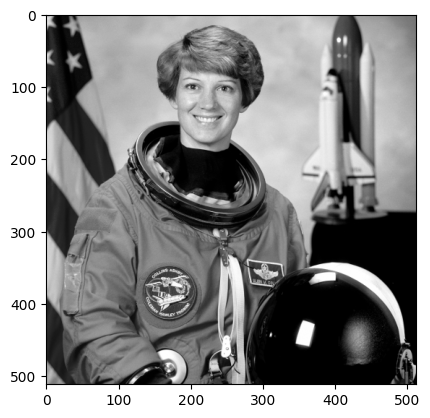

In [7]:
plt_index = 0
def show_and_save():
    global plt_index
    plt.savefig(f"plot_{plt_index}.pdf")
    plt_index += 1
    plt.show()


rgb = data.astronaut()
X = color.rgb2gray(rgb) 
plt.imshow(X, cmap=plt.cm.gray)
show_and_save()

# Transformata Fourier a unei imagini

Transformata Fourier Discretă se extinde ușor la mai multe dimensiuni. Pentru un semnal bidimensional precum o imagine DFT devine:

$$
Y_{m_1,m_2} = \sum_{n_1=0}^{N_1-1}\sum_{n_2=0}^{N_2-1}x_{n_1,n_2}e^{-j2\pi(m_1 n_1/N_1 + m_2 n_2/N_2)}
$$

* unde $n_1$ și $n_2$ sunt pozițile pixelilor pe orizontală, respectiv, pe verticală
* bin-urile rezultate corespund pozițiilor pixelilor
* spectrul este în continuare simetric
* proprietățile transformatei DFT 1D sunt respectate și în cazul celei 2D

În continuare vom folosi rutina generală `fft2` ce servește mai bine activității de învățare, deși pentru semnale reale ar trebui să folosim `rfft2` ce întoarce doar informația esențială (ex. omite simetriile). De asemenea vom analiza spectrul în scală logaritmică pentru a diferenția mai bine magnitudinile bin-urilor DTF.

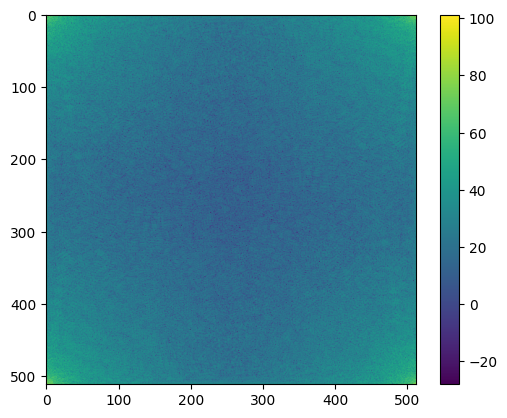

In [8]:
Y = np.fft.fft2(X)
freq_db = 20*np.log10(abs(Y))

plt.imshow(freq_db)
plt.colorbar()
show_and_save()

Operațiile efectuate direct asupra imaginii se reflectă și în spectrul acesteia. Iată un exemplu a unei rotații de 45 de grade:

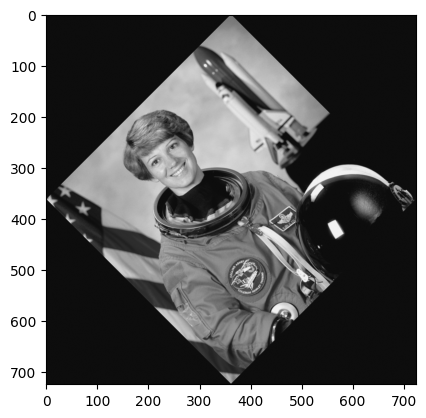

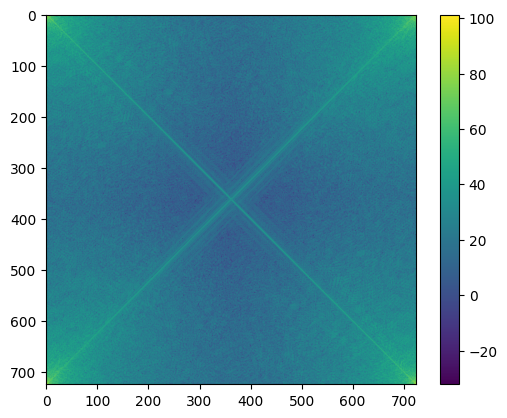

In [9]:
rotate_angle = 45
X45 = ndimage.rotate(X, rotate_angle)
plt.imshow(X45, cmap=plt.cm.gray)
show_and_save()

Y45 = np.fft.fft2(X45)
plt.imshow(20*np.log10(abs(Y45)))
plt.colorbar()
show_and_save()

Momentan pe axe sunt afișate numărul bin-urilor. Pentru a obține frecvențele asociate folosiți `fftfreq`:

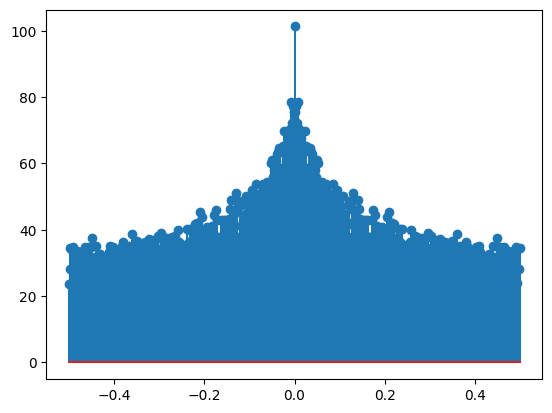

In [10]:
freq_x = np.fft.fftfreq(X.shape[1])
freq_y = np.fft.fftfreq(X.shape[0])

plt.stem(freq_x, freq_db[:][0])
show_and_save()

# Atenuarea frecvențelor înalte

Pentru a anula frecvențele de peste un anumit prag `freq_cutoff` putem pur și simplu anula intrările din spectru și aplica transformata Fourier inversă:

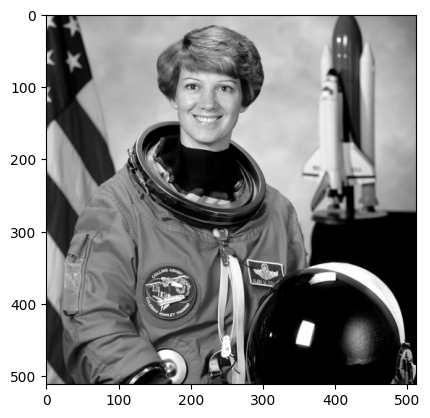

In [11]:
freq_cutoff = 120

Y_cutoff = Y.copy()
Y_cutoff[freq_db > freq_cutoff] = 0
X_cutoff = np.fft.ifft2(Y_cutoff)
X_cutoff = np.real(X_cutoff)    # avoid rounding erros in the complex domain,
                                # in practice use irfft2
plt.imshow(X_cutoff, cmap=plt.cm.gray)
show_and_save()

# Zgomot

Zgomotul alb perturbă în mod egal spectrul semnalului. Este astfel egal distribuit și regăsit în toate bin-urile DFT. [Zgomotul color](https://en.wikipedia.org/wiki/Colors_of_noise) se schimbă de-a lungul frecvențelor.

Putem adăuga zgomot în limita a `pixel_noise` pixeli imaginii folosind `random.randint`:

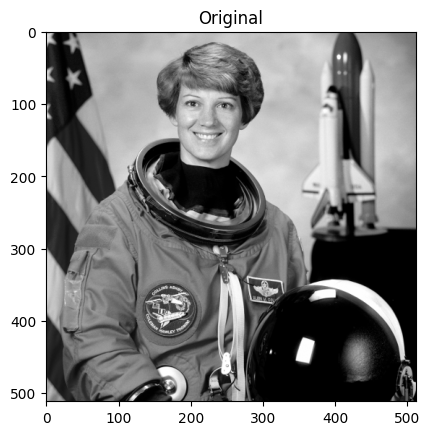

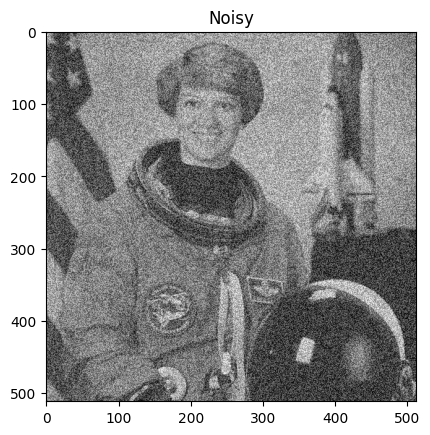

In [12]:
pixel_noise = .5

noise = 2 * pixel_noise * np.random.rand(*X.shape) - pixel_noise
X_noisy = X + noise
plt.imshow(X, cmap=plt.cm.gray)
plt.title('Original')
show_and_save()
plt.imshow(X_noisy, cmap=plt.cm.gray)
plt.title('Noisy')
show_and_save()

# Sarcini

1. Produceți imaginile și spectrul pentru funcțiile de mai jos și dați o explicație scurtă pentru fiecare rezultat.
* $x_{n_1,n_2} = \sin(2\pi n_1 + 3\pi n_2)$
* $x_{n_1,n_2} = \sin(4\pi n_1) + \cos(6\pi n_2)$
* $Y_{0,5} = Y_{0,N-5} = 1\text{, altfel }Y_{m_1,m_2} = 0,\ \forall m_1, m_2$
* $Y_{5,0} = Y_{N-5,0} = 1\text{, altfel }Y_{m_1,m_2} = 0,\ \forall m_1, m_2$
* $Y_{5,5} = Y_{N-5,N-5} = 1\text{, altfel }Y_{m_1,m_2} = 0,\ \forall m_1, m_2$

*Atenție*: $x$ reprezintă informație în domeniul timpului, $Y$ în domeninul frecvenței.

2. Comprimați imaginea cu ratonul de mai sus prin atenuarea frecvențelor înalte până la un prag SNR autoimpus.

3. Eliminați zgomotul adăugat la imaginea cu ratonul produsă mai sus. Prezentați raportul SNR înainte și după.

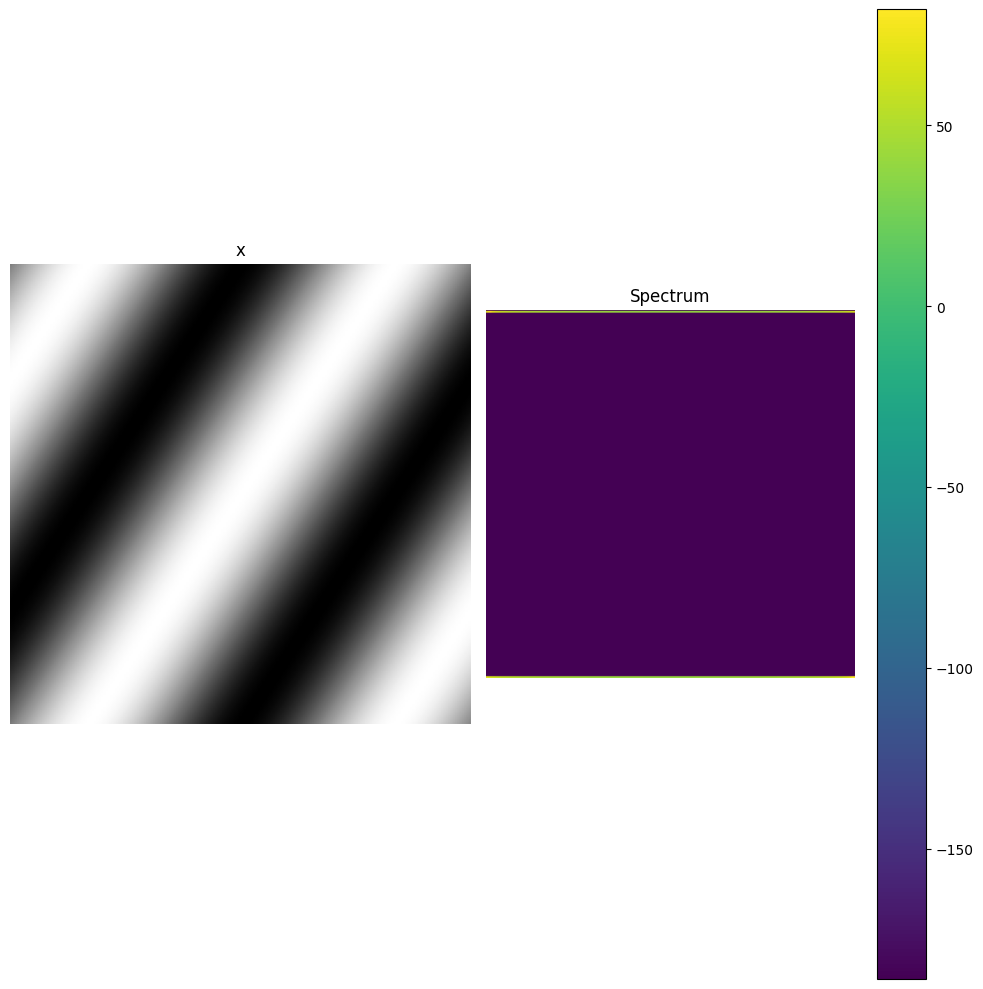

In [25]:
N = 200
FIGSIZE=(10,10)
plt_index = 0
def _1a():
    n = np.arange(N) / N
    n1, n2 = np.meshgrid(n, n, indexing="ij")
    x = np.sin(2*np.pi*n1 + 3*np.pi*n2)
    Y = np.abs(np.fft.fft2(x))
    eps = 5e-10
    Y = np.where(Y < eps, eps, Y) 
    plt.figure(figsize=FIGSIZE)

    plt.subplot(1, 2, 1)
    plt.imshow(x, cmap="gray")
    plt.title("x")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(20*np.log10(Y))
    plt.title("Spectrum")
    plt.colorbar()
    plt.axis("off")

    plt.tight_layout()
    show_and_save()

_1a()


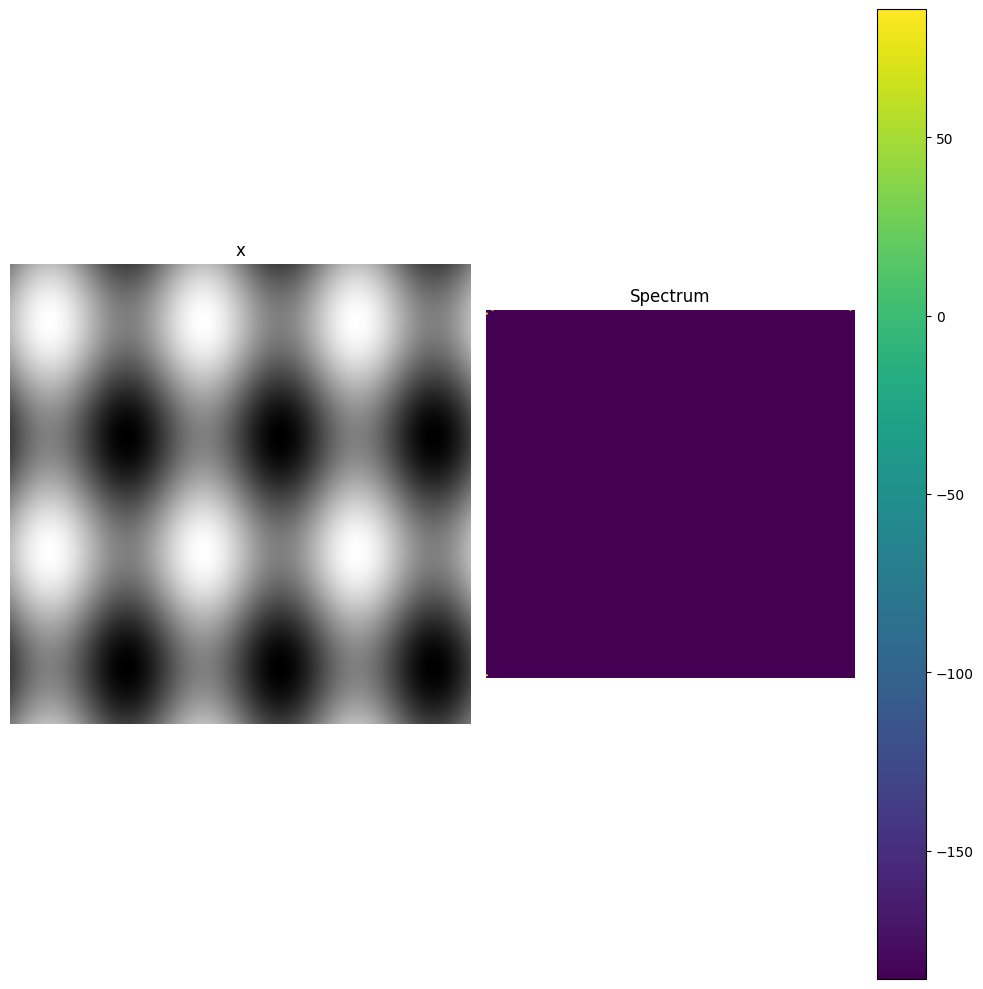

In [26]:
def _1b():
    n = np.arange(N) / N
    n1, n2 = np.meshgrid(n, n, indexing="ij")
    x = np.sin(4*np.pi*n1) + np.sin(6*np.pi*n2)
    Y = np.abs(np.fft.fft2(x))
    eps = 5e-10
    Y = np.where(Y < eps, eps, Y) 
    plt.figure(figsize=FIGSIZE)

    plt.subplot(1, 2, 1)
    plt.imshow(x, cmap="gray")
    plt.title("x")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(20*np.log10(Y))
    plt.title("Spectrum")
    plt.colorbar()
    plt.axis("off")

    plt.tight_layout()
    show_and_save()

_1b()

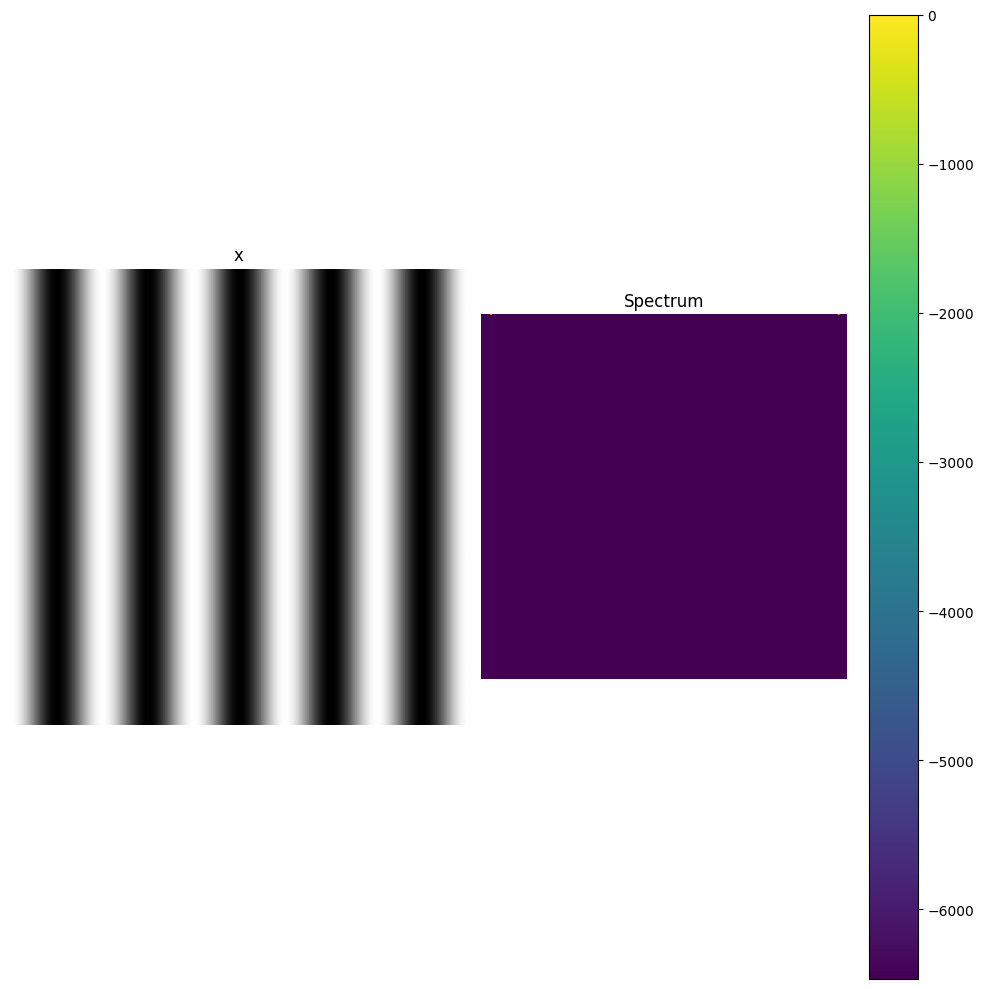

In [27]:
def _1c():
    Y = np.zeros(shape=(N, N))
    Y[0,5] = 1
    Y[0, N-5] = 1
    x = np.fft.ifft2(Y)
    x = np.real(x)
    
    eps = 5e-324
    Y = np.where(Y < eps, eps, Y) 
    plt.figure(figsize=FIGSIZE)

    plt.subplot(1, 2, 1)
    plt.imshow(x, cmap="gray")
    plt.title("x")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(20*np.log10(Y))
    plt.title("Spectrum")
    plt.colorbar()
    plt.axis("off")

    plt.tight_layout()
    show_and_save()

_1c()

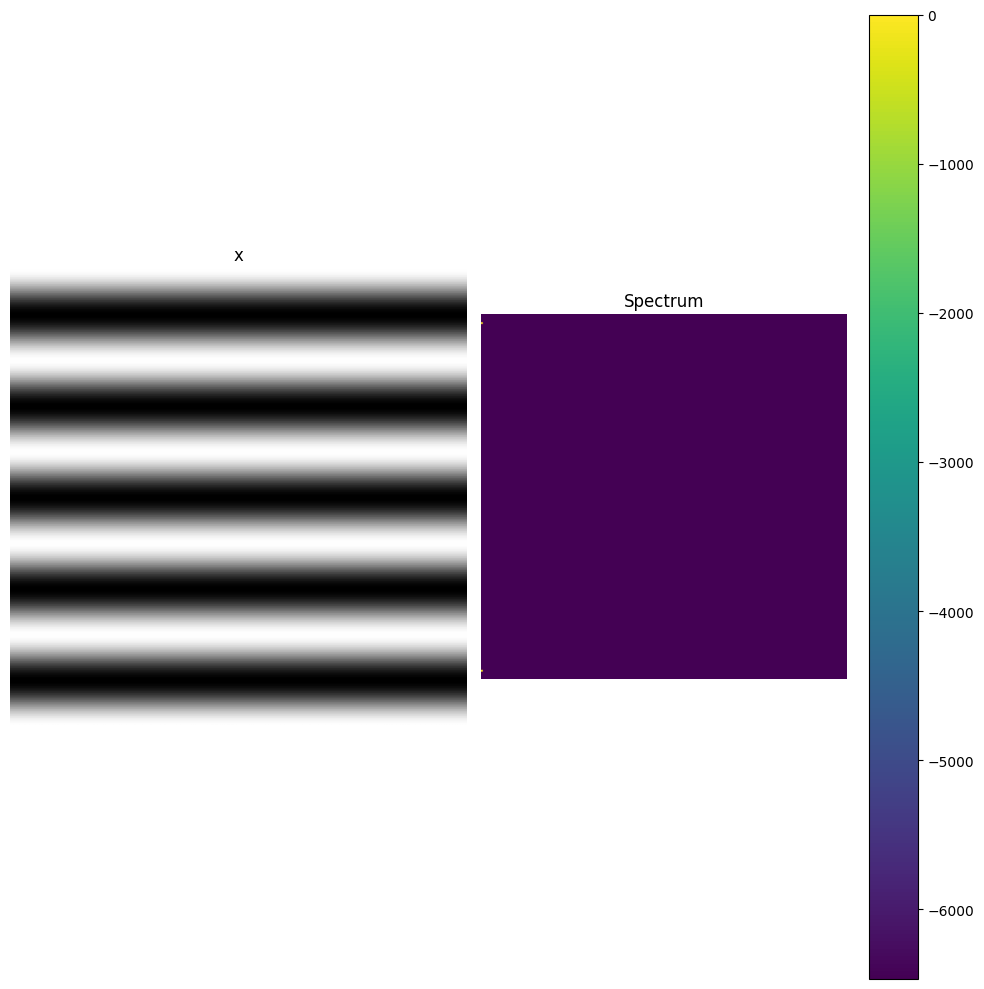

In [28]:
def _1d():
    Y = np.zeros(shape=(N, N))
    Y[5,0] = 1
    Y[N-5, 0] = 1
    x = np.fft.ifft2(Y)
    x = np.real(x)
    
    eps = 5e-324
    Y = np.where(Y < eps, eps, Y) 
    plt.figure(figsize=FIGSIZE)

    plt.subplot(1, 2, 1)
    plt.imshow(x, cmap="gray")
    plt.title("x")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(20*np.log10(Y))
    plt.title("Spectrum")
    plt.colorbar()
    plt.axis("off")

    plt.tight_layout()
    show_and_save()

_1d()

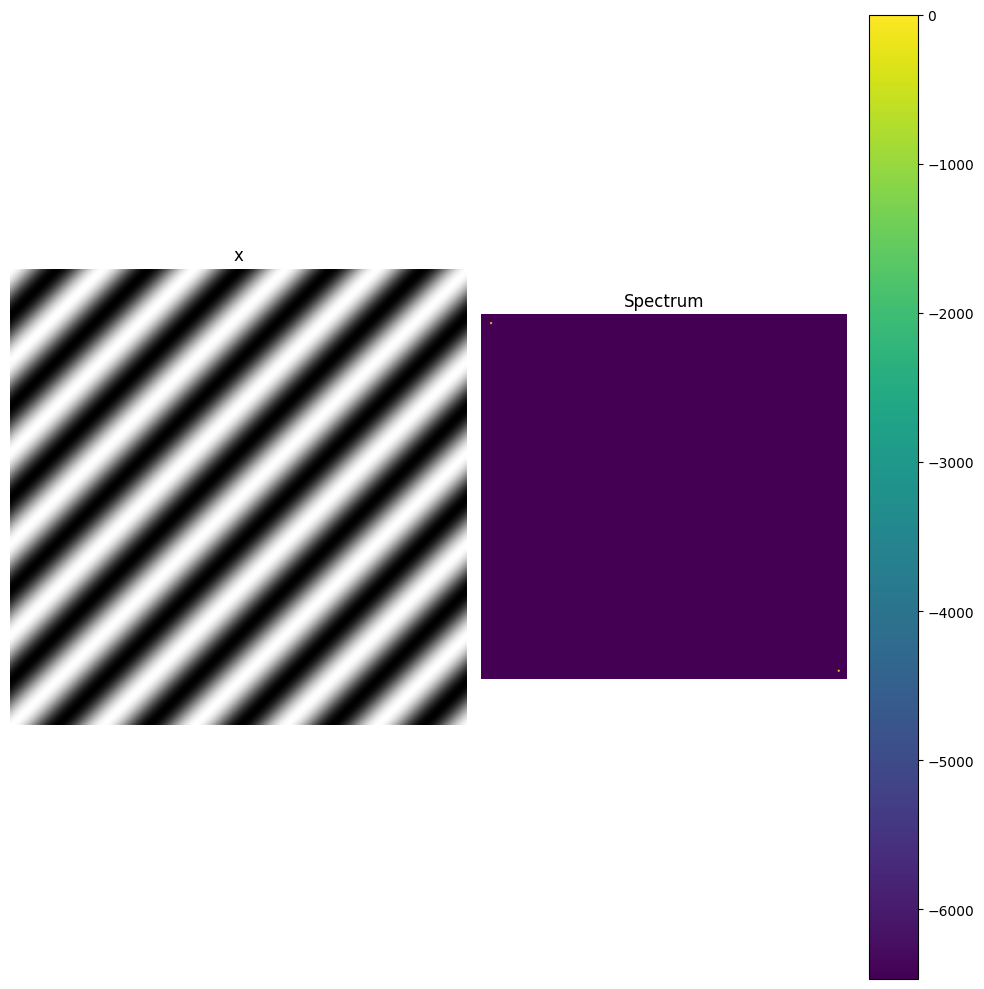

In [29]:
def _1e():
    Y = np.zeros(shape=(N, N))
    n = 5
    Y[5,n] = 1
    Y[N-5, N-n] = 1
    x = np.fft.ifft2(Y)
    x = np.real(x)
    
    eps = 5e-324
    Y = np.where(Y < eps, eps, Y) 
    plt.figure(figsize=FIGSIZE)

    plt.subplot(1, 2, 1)
    plt.imshow(x, cmap="gray")
    plt.title("x")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(20*np.log10(Y))
    plt.title("Spectrum")
    plt.colorbar()
    plt.axis("off")

    plt.tight_layout()
    show_and_save()

_1e()

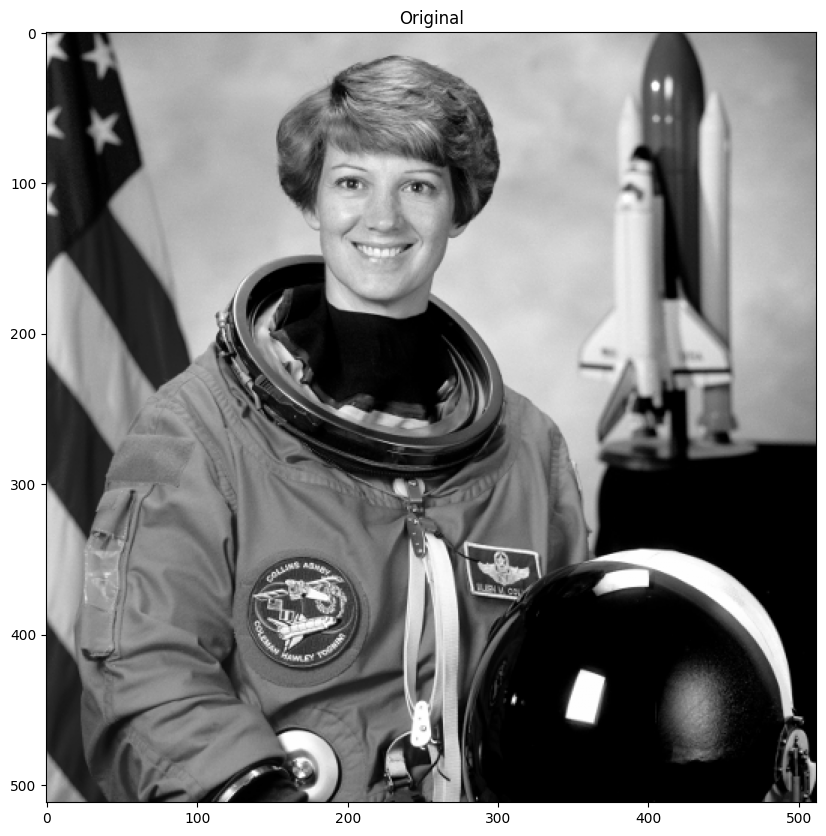

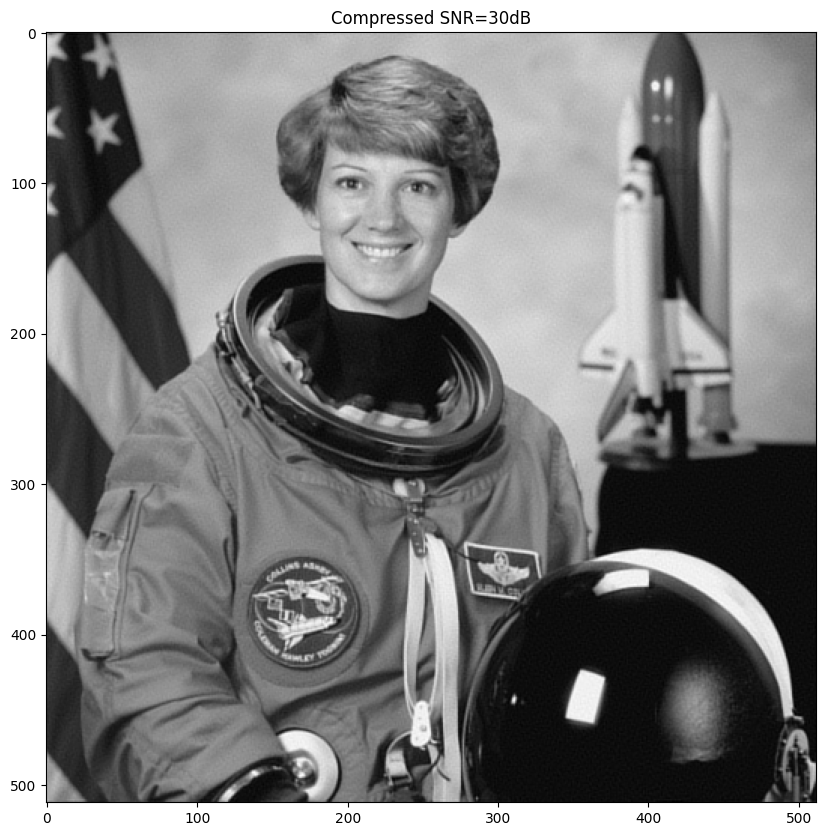

In [30]:
def compress_image(X, snr_db=30):
    Y = np.fft.fft2(X)
    Y_abs = np.abs(Y)
    
    signal_power = np.sum(Y_abs**2)
    target_power = signal_power / (10**(snr_db/10))
    
    flat_Y_abs = Y_abs.flatten()
    sorted_indices = np.argsort(flat_Y_abs)
    
    cumulative_power = np.cumsum(flat_Y_abs[sorted_indices]**2)
    threshold_idx = np.searchsorted(cumulative_power, target_power)
    threshold = flat_Y_abs[sorted_indices[threshold_idx]]
    
    Y_compressed = Y * (Y_abs >= threshold)
    
    X_compressed = np.real(np.fft.ifft2(Y_compressed))
    
    plt.figure(figsize=FIGSIZE)
    plt.imshow(X, cmap='gray')
    plt.title("Original")
    
    plt.figure(figsize=FIGSIZE)
    plt.imshow(X_compressed, cmap='gray')
    plt.title(f"Compressed SNR={snr_db}dB")
    
    show_and_save()
    
compress_image(X, snr_db=30)

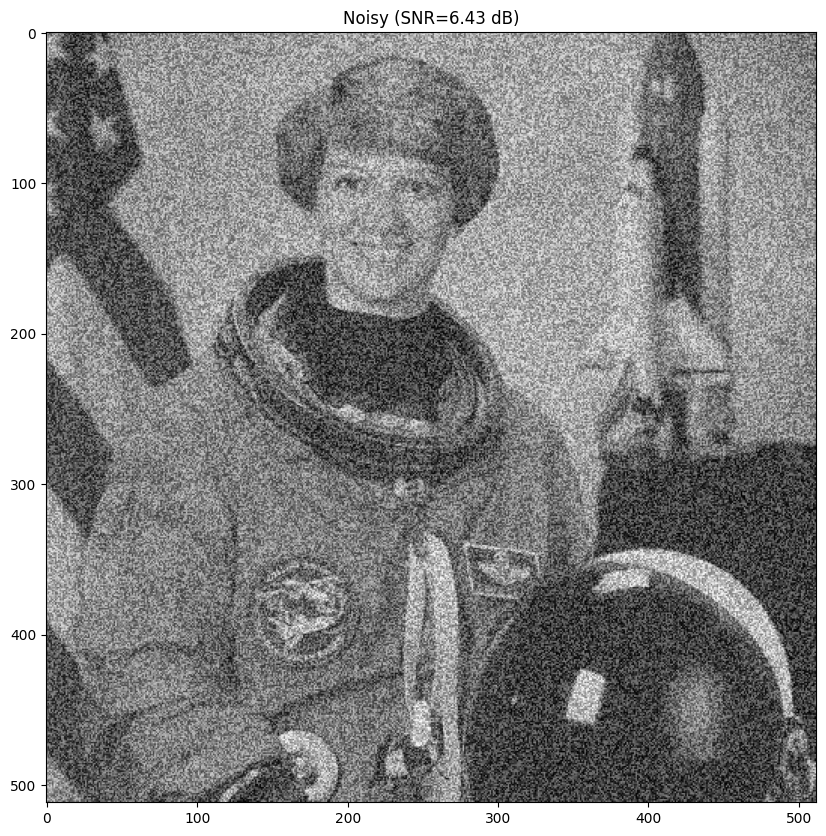

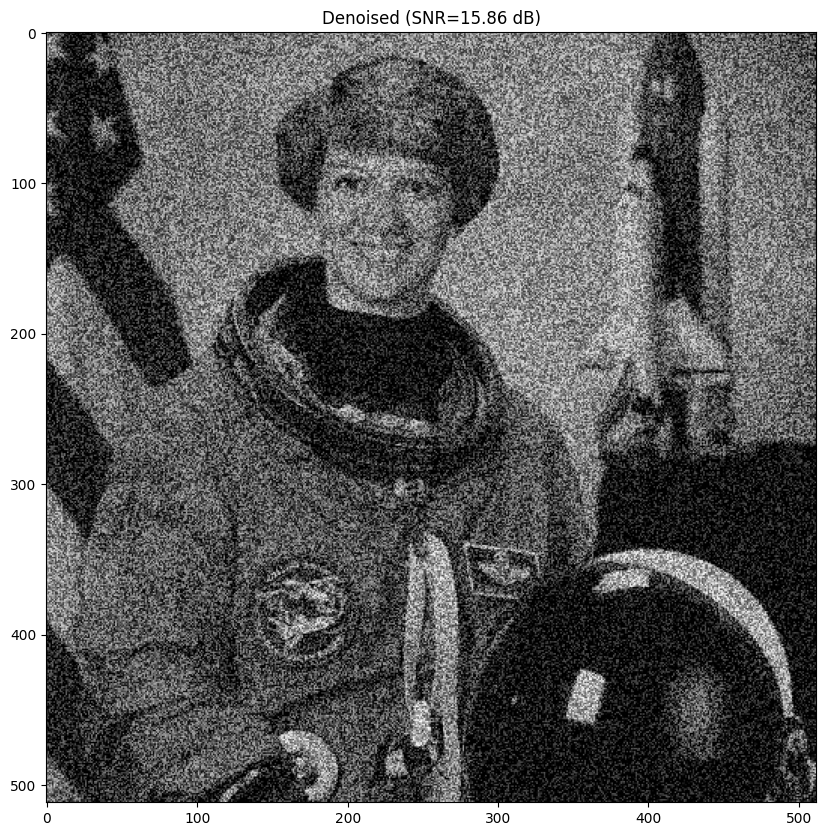

SNR before denoising: 6.431649118284472
SNR after denoising: 15.864468574013939


In [31]:
from scipy.ndimage import gaussian_filter

def denoise_and_snr(X_noisy, noise):
    eps = 5e-324
    
    # SNR before denoising
    signal_power = np.sum(X_noisy**2)
    noise_power = np.sum(noise**2)
    snr_before = 10 * np.log10(signal_power / noise_power)
    
    # Denoise with Gaussian filter
    X_denoised = gaussian_filter(X_noisy, sigma=.2)
    X_denoised = np.where(X_denoised < eps, eps, X_denoised)
    
    # Estimate remaining noise
    noise_remaining = X_noisy - X_denoised
    snr_after = 10 * np.log10(np.sum(X_denoised**2) / np.sum(noise_remaining**2))
    
    # Show images
    plt.figure(figsize=FIGSIZE); plt.imshow(X_noisy, cmap="gray"); plt.title(f"Noisy (SNR={snr_before:.2f} dB)")
    plt.figure(figsize=FIGSIZE); plt.imshow(X_denoised, cmap="gray"); plt.title(f"Denoised (SNR={snr_after:.2f} dB)")
    show_and_save()
    
    return snr_before, snr_after

snr_before, snr_after = denoise_and_snr(X_noisy, noise)
print("SNR before denoising:", snr_before)
print("SNR after denoising:", snr_after)